In [52]:
import cupy as cp
from cupyx import scatter_add
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from includes.preprocessor import write_keywords,write_birth,write_parameters
from includes.gamma import domain_mgr, heat_solve_mgr
%matplotlib notebook
cp.cuda.Device(1).use()
!nvidia-smi

Tue Apr 20 15:48:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:01:00.0 Off |                  Off |
| 34%   41C    P8    27W / 260W |    195MiB / 48598MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:21:00.0 Off |                  Off |
| 33%   

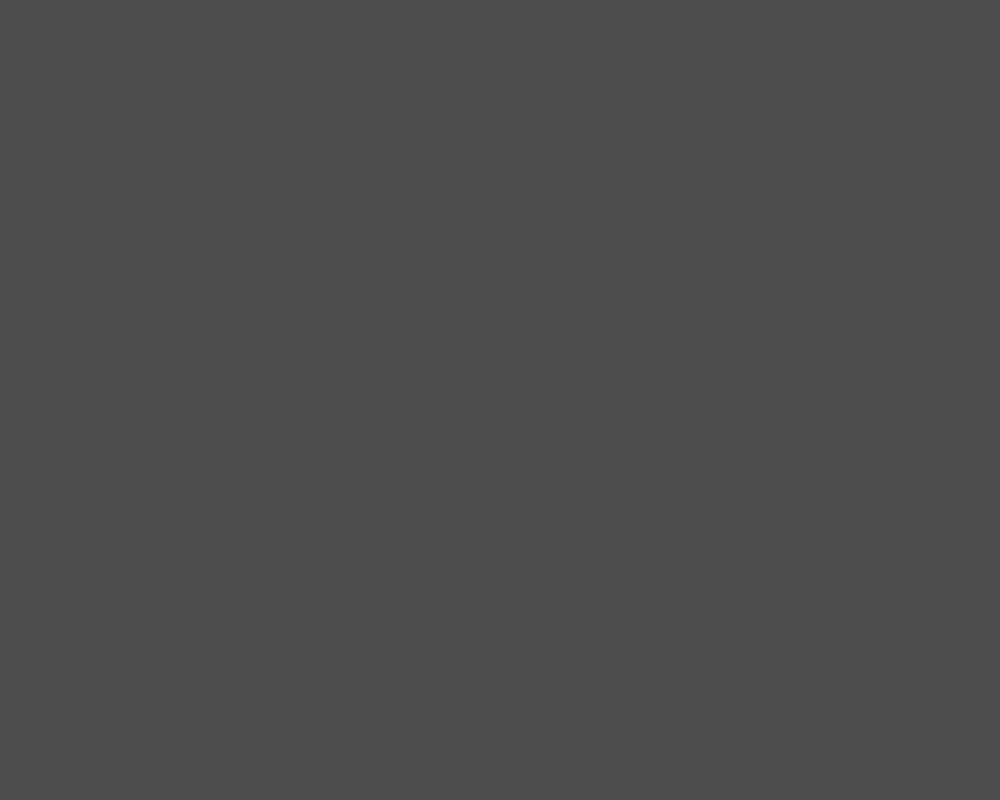

In [53]:
file_name = 'input_files/cylinder.inp'
output_file = 'input_files/cylinder.k'
toolpath_file = 'input_files/toolpath.crs'
height = 15
radius = 1.5
path_resolution = 0.2
write_keywords(file_name,output_file,15)
write_birth(output_file,toolpath_file,path_resolution,radius,nFrame=100)
write_parameters(output_file)

In [ ]:
domain = domain_mgr(filename='input_files/cylinder.k',toolpath_file='input_files/toolpath.crs')

Time of reading input files: 2.2982754707336426
Time of calculating critical timestep: 0.04874587059020996


In [ ]:
%%time
heat_solver = heat_solve_mgr(domain)
data = []
domain.current_time = 0
endtime = 2000
timestep = int(endtime/domain.dt)+1
timestep = 14000
for t in range(1,timestep):
    heat_solver.time_integration()
    heat_solver.calculate_melt()
    if t % 500 == 0:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
#    data.append(np.array(heat_solver.temperature.get()))
    data.append(heat_solver.melt_depth)

In [ ]:
import pyvista as pv
from pyvirtualdisplay import Display
import vtk
display = Display(visible=0)
_ = display.start()
active_elements = domain.elements[domain.active_elements].tolist()
active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = domain.nodes.get()
active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
active_grid.point_arrays['temp'] = heat_solver.temperature.get()
p = pv.Plotter(window_size=(1000,800))
p.camera_position = ((0, -100, 180),(0, 0, 0),(0.0, 0.0, 1.0))
p.add_mesh(active_grid, show_edges=True, scalars='temp',cmap="coolwarm",clim=[300,2300])
p.show()